# Flashbots Analysis

## Code preamble

In [1]:
from mevlib.utils.utils import connect_to_mongodb
import pandas as pd
from pymongo import ASCENDING, DESCENDING, MongoClient
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pprint import pprint
import matplotlib.dates as mdates
import locale
import datetime
from functools import reduce
locale.setlocale(locale.LC_ALL, 'en_US')
style = 'seaborn-whitegrid'

# Remote connection

Connect to MongoDB and get a connection object for our collection. To run this
against your own MongoDB instance, set the following three environment
variables: MONGODB_ENDPOINT, MONGODB_PASSWORD, MONGODB_USERNAME. For example:
```bash
export MONGODB_ENDPOINT="mongodb://localhost:27017"
export MONGODB_PASSWORD="mypassword"
export MONGODB_USERNAME="root"
```

In [2]:
db = connect_to_mongodb()
confirmed_mevs = db.flashbots.confirmed_mevs
insertions = db.flashbots.confirmed_mevs
flashbots_txs = db.flashbots.flashbots_txs

# Local connection

In [3]:
def connect_to_mongodb_no_auth():
    return MongoClient("mongodb://localhost:27017")

db = connect_to_mongodb_no_auth()
confirmed_mevs = db.flashbots.insertions
insertions = db.flashbots.insertions
flashbots_txs = db.flashbots.flashbots_txs
liquidations = db.flashbots.liquidation
arbitrages = db.flashbots.arbitration

# Constants

In [4]:
monthly_block_ranges = [
    (11565019, 11766938), # January 2021
    (11766939, 11948959), # February 2021
    (11948960, 12150244), # March 2021
    (12150245, 12344944), # April 2021
    (12344945, 12545218), # May 2021
    (12545219, 12738508), # June 2021
    (12738509, 12936339), # July 2021
    (12936340, 13136426), # August 2021
    (13136427, 13330089), # September 2021
    (13330090, 13527858), # October 2021
    (13527859, 13717846), # November 2021
    (13717847, 13916165), # December 2021
    (13916166, 14116760), # January 2022
    (14116761, 14297758), # February 2022
]

months = [f'{i}/2021' for i in range(1, 13)]
months.extend([f'{i}/2022' for i in range(1, 3)])



# Analysis

When is our first block from? 

In [148]:
first_block = confirmed_mevs.find().sort("block_number", ASCENDING).limit(1)[0]["block_number"]

print(f"First collected block: {first_block}")

First collected block: 10000071


When was the last block from?

In [4]:
last_block = confirmed_mevs.find().sort("block_number", DESCENDING).limit(1)[0]["block_number"]

print(f"Last collected block: {last_block}")

Last collected block: 14444710


## Useful queries

In [5]:
is_flashbots_query = {"flashbots_bundle": True}
is_non_flashbots_query = {"flashbots_bundle": False}

## When is the first Flashbots block from?

Christof's measurements go back to before Flashbots was operational. This calculation shows the first time the Flashbots API.

In [6]:
first_flashbots_block_raw = confirmed_mevs.find(is_flashbots_query).sort("block_number", ASCENDING).limit(1)[0]
first_flashbots_block = first_flashbots_block_raw["block_number"]

first_flashbots_block_fb_api = flashbots_txs.find({}).sort("block_number", ASCENDING).limit(1)[0]
first_flashbots_block_reported = first_flashbots_block_fb_api["block_number"]

first_flashbots_block_reported_dt = datetime.datetime(2021, 2, 11, 7, 56, 47),

print(f"First Flashbots insertion block detected: {first_flashbots_block}")
print(f"First Flashbots block reported: {first_flashbots_block_reported}")

First Flashbots insertion block detected: 11986936
First Flashbots block reported: 11834049


## Queries that depend on the first block

In [7]:
before_fb_query = {"block_number": {"$lt": first_flashbots_block}}
non_fb_before_query = is_non_flashbots_query | before_fb_query
after_fb_query = {"block_number": {"$gte": first_flashbots_block}}
is_fb_after_fb_query = is_flashbots_query | after_fb_query
non_fb_after_query = is_non_flashbots_query | after_fb_query
unprofitable_tx_query = {"profit_eth": {"$lte": 0}}
unprofitable_fb_query = is_fb_after_fb_query | unprofitable_tx_query


## What proportion of Ethereum transactions went through Flashbots?

How many transactions went through Flashbots during this time span?

In [8]:
flashbots_txs_count = confirmed_mevs.count_documents(is_flashbots_query)
print(f"Flashbots insertion transactions (detected): {flashbots_txs_count}")

Flashbots insertion transactions (detected): 485680


Are there any blocks that were reported by the Flashbots API but that we did not detect?

In [9]:
fb_api_tx_count = flashbots_txs.count_documents({})
print(f"Flashbots transactions (reported): {fb_api_tx_count}")

Flashbots transactions (reported): 1259888


How many transactions did not go through Flashbots during this time span?

In [10]:
non_flashbots_txs = confirmed_mevs.count_documents(is_non_flashbots_query)
print(f"Non-Flashbots transactions: {non_flashbots_txs}")

Non-Flashbots transactions: 534364


### Flashbots transactions over full time interval

We start by plotting the ratio of Flashbots transactions to non-Flashbots transactions over the entire time interval.

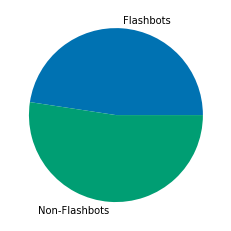

In [11]:
plt.style.use('seaborn-colorblind')
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie([flashbots_txs_count, non_flashbots_txs], labels = ["Flashbots", "Non-Flashbots"])
plt.show() 

We can see that a little less than half of the transactions used flashbots over
the _entire_ time span. However, we must ask what these ratios look like
independently before and after Flashbots started. Really, we can only go back to
when the Flashbots API provides history from, we do not know whether or not that
truly coincides with the start of Flashbots.

### Flashbots transactions before Flashbots started (sanity check, should be zero)

In [12]:
flashbots_txs_before = confirmed_mevs.count_documents(is_flashbots_query | before_fb_query)

non_flashbots_txs_before = confirmed_mevs.count_documents(non_fb_before_query)
total_mev_before_fb = confirmed_mevs.count_documents(before_fb_query)

print(f"Flashbots transactions: {flashbots_txs_before}")
print(f"MEV transactions before Flashbots: {total_mev_before_fb}")
print(f"Non-Flashbots transactions before Flashbots: {non_flashbots_txs_before}")
assert non_flashbots_txs_before == total_mev_before_fb
assert flashbots_txs_before == 0

Flashbots transactions: 0
MEV transactions before Flashbots: 356464
Non-Flashbots transactions before Flashbots: 356464


We see the expected zero Flashbots transactions, which grants us a little more confidence in the data.

### Flashbots transactions *after* Flashbots started

In [13]:
flashbots_txs_after = confirmed_mevs.count_documents(is_fb_after_fb_query)

non_flashbots_txs_after = confirmed_mevs.count_documents(non_fb_after_query)

print(f"Flashbots transactions: {flashbots_txs_after}")
print(f"Non-Flashbots transactions after Flashbots began: {non_flashbots_txs_after}")

Flashbots transactions: 485680
Non-Flashbots transactions after Flashbots began: 177900


We can now plot the ratio of Flashbots transactions to non-Flashbots transactions over *only* the time interval that Flashbots was operational.

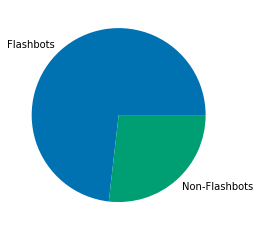

In [14]:
plt.style.use('seaborn-colorblind')
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie([flashbots_txs_after, non_flashbots_txs_after], labels = ["Flashbots", "Non-Flashbots"])
plt.show() 

## How have frontrunning profits changed as a result of Flashbots?

### Searcher profits

We compare below the profits that frontrunners were making in the pre-Flashbots days, to their profits since then. This is the average profit per transaction.

In [15]:
def make_pipeline(match_query, group_operation):
    return [
        {
            "$match": match_query
        },
        {
            "$group": group_operation
        }    
    ]

def make_sorted_pipeline(match_query, group_operation, sort_operation):
    pipeline = make_pipeline(match_query, group_operation)
    pipeline.append(
        {
            "$sort": sort_operation
        })
    return pipeline

def make_profit_pipline(match_query):
    sum_profit_operation = {
        "_id": None,
        "profit" : {"$sum": "$profit_eth"}
    }

    return make_pipeline(match_query, sum_profit_operation)


def calculate_profit(match):
    return confirmed_mevs.aggregate(make_profit_pipline(match)).next()["profit"]


In [16]:
before_fb_profit = calculate_profit(non_fb_before_query)
print(f"Total profits before Flashbots began: {before_fb_profit}")

after_fb_profit = calculate_profit(after_fb_query)
print(f"Total profits after Flashbots began: {after_fb_profit}")

before_fb_avg_profit = before_fb_profit / non_flashbots_txs_before
print(f"Average profit (per transaction) before Flashbots began: {before_fb_avg_profit}")

total_txs_after = confirmed_mevs.count_documents(after_fb_query)
after_fb_avg_profit = after_fb_profit / total_txs_after
print(f"Average profit (per transaction) after Flashbots began: {after_fb_avg_profit}")

fb_after_fb_profit = calculate_profit(is_fb_after_fb_query)
fb_avg_profit_after_fb = fb_after_fb_profit / flashbots_txs_after
print(f"Average profit (per transaction) of Flashbots transactsion after Flashbots began: {fb_avg_profit_after_fb}")

non_fb_after_fb_profit = calculate_profit(non_fb_after_query)
non_fb_avg_profit_after_fb = non_fb_after_fb_profit / non_flashbots_txs_after
print(f"Average profit (per transaction) of *non*-Flashbots transactions after Flashbots began: {non_fb_avg_profit_after_fb}")

Total profits before Flashbots began: 50007.31162430552
Total profits after Flashbots began: 29682.07729843961
Average profit (per transaction) before Flashbots began: 0.14028713032537793
Average profit (per transaction) after Flashbots began: 0.04473021685168271
Average profit (per transaction) of Flashbots transactsion after Flashbots began: 0.02037079975101507
Average profit (per transaction) of *non*-Flashbots transactions after Flashbots began: 0.11123320559509056


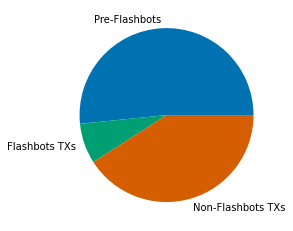

In [17]:
plt.style.use('seaborn-colorblind')
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

profit_segments = [before_fb_avg_profit, fb_avg_profit_after_fb, non_fb_avg_profit_after_fb]
profit_labels = ["Pre-Flashbots", "Flashbots TXs", "Non-Flashbots TXs"]

ax.pie(profit_segments, labels = profit_labels, normalize=True)
plt.show() 

This shows the ratio of average profits for all pre-Flashbots transactions,
non-Flashbots transactions after Flashbots began, and Flashbots transactions
after Flashbots begain. The interesting thing about this plot is that since
Flashbots began, MEV transactions that have circumvented Flashbots have been
more signifcantly more profitable. However, these profits are only calculated
for searchers.

We can also view the same data in absolute terms.

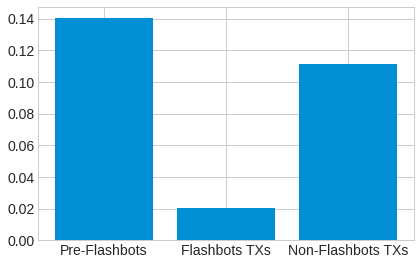

In [30]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots()
#fig.patch.set_facecolor('white')

plt.bar(profit_labels, profit_segments)
plt.show() 

We also view these changing profits as a function of time since Flashbots began for both Flashbots and non-Flashbots tranactions.

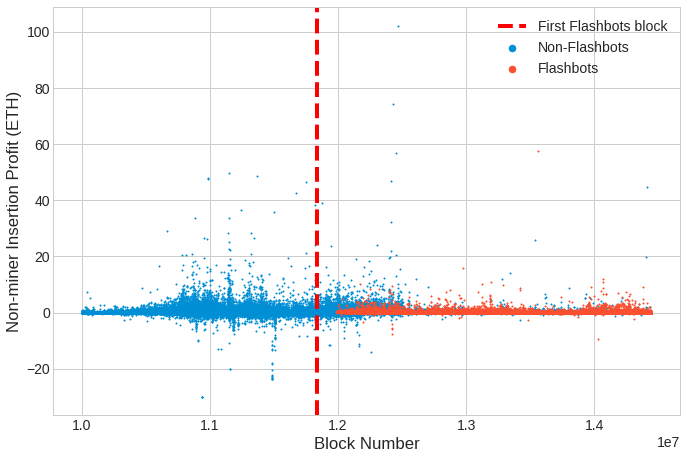

In [32]:
plt.style.use(style)
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
fig.set_figwidth(10)
fig.set_figheight(7)

non_fb_after_df = pd.DataFrame(list(confirmed_mevs.find(is_non_flashbots_query, {"block_number":1, "profit_eth":1})))
fb_after_df = pd.DataFrame(list(confirmed_mevs.find(is_fb_after_fb_query, {"block_number":1, "profit_eth":1})))
ax.scatter(non_fb_after_df.block_number, non_fb_after_df.profit_eth, s=2)
ax.scatter(fb_after_df.block_number, fb_after_df.profit_eth, s=2)
plt.xlabel("Block Number")
plt.ylabel("Non-miner Insertion Profit (ETH)")
plt.axvline(x=first_flashbots_block_reported, color='red', linestyle='--')

ax.legend(labels=["First Flashbots block", "Non-Flashbots", "Flashbots"], markerscale=5.0)


This plot shows the profits of both Flashbots and non-Flashbots transactions
since the beginning of our measurements. Interestingly, we see that
non-Flashbots transactions have a less predictable payoff, and frequently return
negative profit.

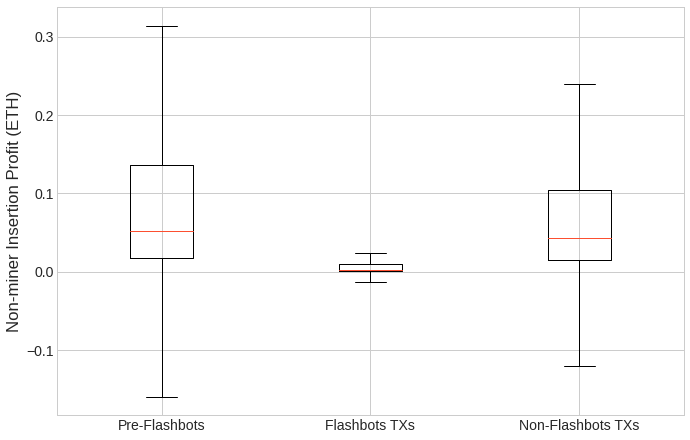

In [34]:
plt.style.use(style)
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
fig.set_figwidth(10)
fig.set_figheight(7)

non_fb_before_profits_df = pd.DataFrame(list(confirmed_mevs.find(non_fb_before_query, {"profit_eth":1})))
non_fb_after_profits_df = pd.DataFrame(list(confirmed_mevs.find(non_fb_after_query, {"profit_eth":1})))

ind_profits = [non_fb_before_profits_df.profit_eth, fb_after_df.profit_eth, non_fb_after_profits_df.profit_eth]
ind_profit_labels = ["Pre-Flashbots", "Flashbots TXs", "Non-Flashbots TXs"]

plt.boxplot(x=ind_profits, notch=False, sym='', labels=ind_profit_labels)
plt.ylabel("Non-miner Insertion Profit (ETH)")
plt.show() 

Variance is much lower for Flashbots transactions, but so is the average profit.

### Miner profits

Below we show how much miners are making pre- and post-Flashbots.

In [36]:
def make_miner_profit_pipline(match_query):
    sum_profit_operation = {
        "_id": None,
        "profit" : {"$sum": "$cost_eth"}
    }

    return make_pipeline(match_query, sum_profit_operation)


def calculate_miner_profit(match):
    return confirmed_mevs.aggregate(make_miner_profit_pipline(match)).next()["profit"]


In [38]:
non_fb_txs = pd.DataFrame(list(confirmed_mevs.find(is_non_flashbots_query, {"block_timestamp":1, "block_number":1, "cost_eth":1, "profit_eth":1})))
fb_miner_after_df = pd.DataFrame(list(confirmed_mevs.find(is_fb_after_fb_query, {"block_timestamp":1, "block_number":1, "cost_eth":1, "profit_eth":1})))

/nix/store/vmb9rpdkdjcparf851vjdzqfj1jfchs6-python3.9-ipython-7.28.0/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


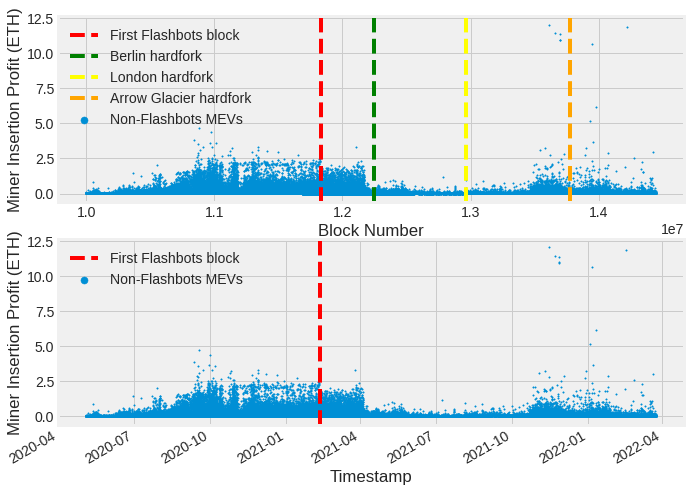

In [40]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(2, 1, figsize=(10, 7))

fig.patch.set_facecolor('white')
fig.set_figwidth(10)
fig.set_figheight(7)

ax[0].scatter(non_fb_txs.block_number, non_fb_txs.cost_eth, s=2)

ax[0].set_xlabel("Block Number")
ax[0].set_ylabel("Miner Insertion Profit (ETH)")
ax[0].axvline(x=first_flashbots_block_reported, color='red', linestyle='--')
ax[0].axvline(x=12244000, color='green', linestyle='--')
ax[0].axvline(x=12965000, color='yellow', linestyle='--')

# Arrow glacier just delays the "difficulty bomb"
ax[0].axvline(x=13773000, color='orange', linestyle='--')


ax[0].legend(labels=["First Flashbots block", "Berlin hardfork", "London hardfork", "Arrow Glacier hardfork", "Non-Flashbots MEVs"], markerscale=5.0)


ax[1].scatter(pd.to_datetime(non_fb_txs.block_timestamp, unit = 's'), non_fb_txs.cost_eth, s=2)

ax[1].set_xlabel("Timestamp")
ax[1].set_ylabel("Miner Insertion Profit (ETH)")
ax[1].axvline(x=first_flashbots_block_reported_dt, color='red', linestyle='--')

ax[1].legend(labels=["First Flashbots block", "Non-Flashbots MEVs"], markerscale=5.0)

for label in ax[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')


This plot is showing the miner profits for non-Flashbots insertion transactions. There is
an anomaly in the post-Flashbots epoch. **Why is it there?**

In [42]:
def avg_miner_profit_calc(match):
    group = {"_id": "$block_number", "Avg": {"$avg": "$cost_eth"}}
    sort_op = {"_id": 1}
    pipeline = make_sorted_pipeline(match, group, sort_op)
    return pd.DataFrame(list(confirmed_mevs.aggregate(pipeline)))

In [44]:
avg_miner_profit_before_fb = avg_miner_profit_calc(before_fb_query)
avg_miner_profit_non_fb_after_fb = avg_miner_profit_calc(non_fb_after_query)
avg_miner_profit_fb_after_fb = avg_miner_profit_calc(is_fb_after_fb_query)

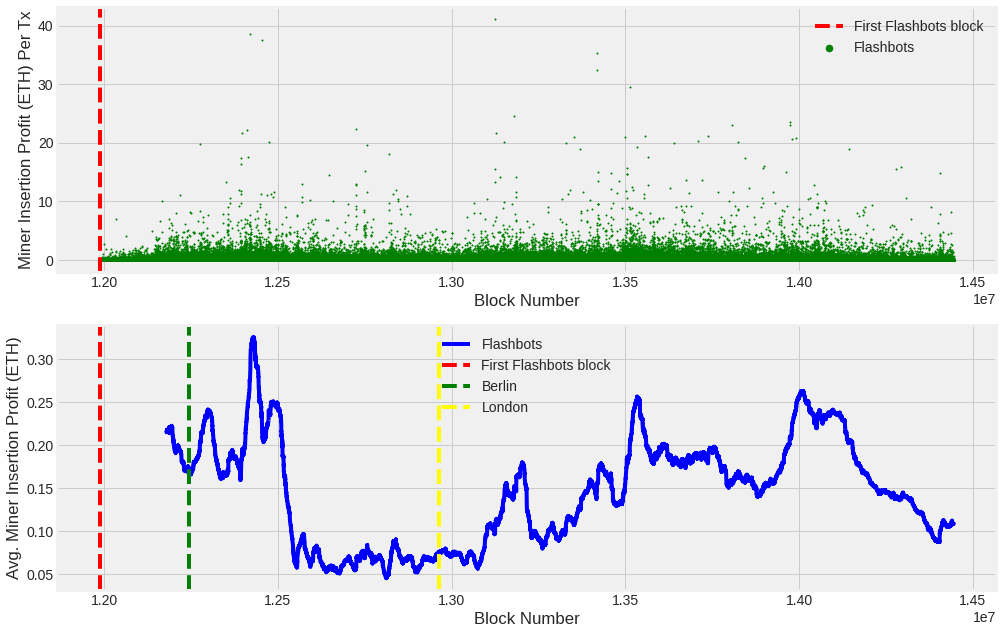

In [46]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
fig.patch.set_facecolor('white')
#fig.set_figwidth(10)
#fig.set_figheight(7)

ax[0].scatter(fb_miner_after_df.block_number, fb_miner_after_df.cost_eth, s=2, color='green', label="Flashbots")
ax[0].axvline(x=first_flashbots_block, color='red', linestyle='--', label="First Flashbots block")

# _id is block_number
blocks_per_day = 6446
ax[1].plot(avg_miner_profit_fb_after_fb._id, avg_miner_profit_fb_after_fb.Avg.rolling(blocks_per_day).mean(), color='blue', label="Flashbots")
ax[1].axvline(x=first_flashbots_block, color='red', linestyle='--', label="First Flashbots block")
ax[1].axvline(x=12244000, color='green', linestyle='--', label="Berlin")
ax[1].axvline(x=12965000, color='yellow', linestyle='--', label="London")

ax[0].set_xlabel("Block Number")
ax[0].set_ylabel("Miner Insertion Profit (ETH) Per Tx")
ax[1].set_xlabel("Block Number")
ax[1].set_ylabel("Avg. Miner Insertion Profit (ETH)")

ax[0].legend(markerscale=5.0)
ax[1].legend()

plt.show()

The above plots show miner profits for Flashbots transactions. The top plot shows the miner profit per transaction; we see no discernable pattern.

The lower plot shows a rolling average of miner profits over the course of 6446 blocks (~24 hours). There appear to be patterns, but it is not clear what we can infer from them.

In [48]:
def avg_miner_profit_calc_dt(match_query):
    match = {"$match": match_query}
    group = {"$group": {"_id": "$block_timestamp", "Avg": {"$avg": "$cost_eth"}}}
    sort = {"$sort": {"_id": 1}}
    add_fields = {"$addFields": {"counter": 1}}
    pipeline = [match, group, sort, add_fields] 
    df = pd.DataFrame(list(confirmed_mevs.aggregate(pipeline)))
    df.index = pd.to_datetime(df["_id"], unit='s')
    return df

In [50]:
def calculate_rolling_avg(df, offset):
    df["daily_rolling_sum"] = df.rolling(offset).sum().counter
    return df

def calculate_daily_rolling_avg(df):
    return calculate_rolling_avg(df, "1D")

def calculate_weekly_rolling_avg(df):
    return calculate_rolling_avg(df, "7D")

In [52]:
txs_before_fb_dt = calculate_weekly_rolling_avg(avg_miner_profit_calc_dt(before_fb_query))
txs_non_fb_after_fb_dt = calculate_weekly_rolling_avg(avg_miner_profit_calc_dt(non_fb_after_query))
txs_fb_after_fb_dt = calculate_weekly_rolling_avg(avg_miner_profit_calc_dt(is_fb_after_fb_query))

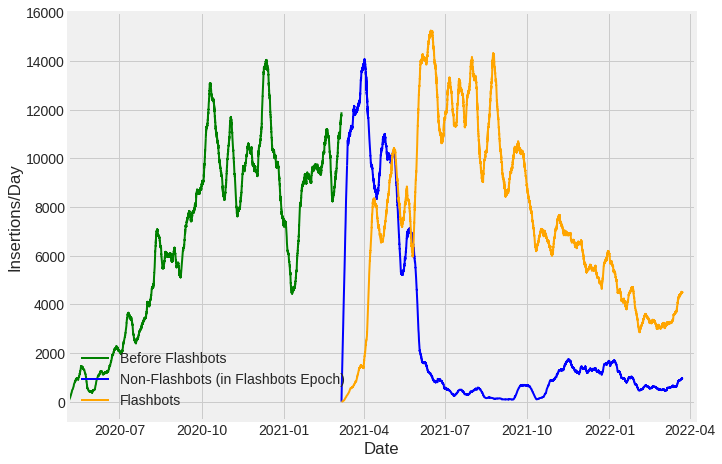

In [54]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10, 7))
fig.patch.set_facecolor('white')
fig.set_figwidth(10)
fig.set_figheight(7)

ax.set_xlim([datetime.datetime(2020, 5, 4, 20, 5, 27), datetime.datetime(2022, 4, 6, 20, 5, 27)])
ax.plot(txs_before_fb_dt.index, txs_before_fb_dt['daily_rolling_sum'], color='green', label="Before Flashbots", linewidth=2)
ax.plot(txs_non_fb_after_fb_dt.index, txs_non_fb_after_fb_dt['daily_rolling_sum'], color='blue', label="Non-Flashbots (in Flashbots Epoch)", linewidth=2)
ax.plot(txs_fb_after_fb_dt.index, txs_fb_after_fb_dt['daily_rolling_sum'], color='orange', label="Flashbots", linewidth=2)

ax.set_xlabel("Date")
ax.set_ylabel("Insertions/Day")

ax.legend(markerscale=5.0)

plt.show()

The above plot tells us that when Flashbots started, it quickly got popular. When it was popular, insertions in the puplic pool grew sparse. Eventually, it got less popular, but non-Flashbots insertions only mildly recovered.

We next show how per-transaction profits compare between miners and searchers.

Miner avg. profit (non-Flashbots): 0.048338383601882765
Miner avg. profit (Flashbots): 0.12547094303246237
Miner median profit (non-Flashbots): 0.023564708684088255
Miner median profit (Flashbots): 0.04235711216588352
Miner std. profit (non-Flashbots): 0.12687208372242229
Miner std. profit (Flashbots): 0.41548771333159545
Average increase in profit: 2.5956793273405054


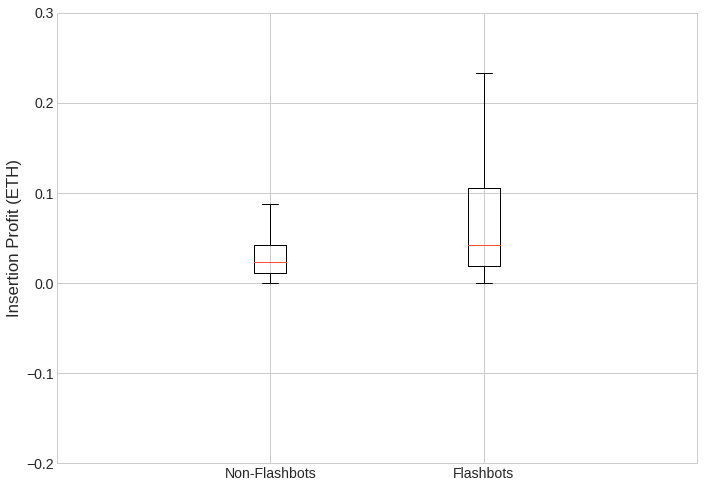

In [56]:
plt.style.use(style)
fig, ax = plt.subplots(figsize=(10, 7))
#fig.patch.set_facecolor('white')

miner_profits = [non_fb_txs.cost_eth, fb_miner_after_df.cost_eth]
#searcher_profits = [non_fb_txs.profit_eth, fb_miner_after_df.profit_eth]
profit_labels = ["Non-Flashbots", "Flashbots"]

ax.boxplot(x=miner_profits, notch=False, sym='', labels=profit_labels)
#ax[1].boxplot(x=searcher_profits, notch=False, sym='', labels=profit_labels)

ax.set_ylabel("Insertion Profit (ETH)")
#ax.set_xlabel("Miners")
ax.set_ylim([-0.2, 0.3])
ax.set_xlim([0, 3])

#ax[1].set_xlabel("Searchers")

#plt.show()
print(f"Miner avg. profit (non-Flashbots): {non_fb_txs.cost_eth.mean()}")
print(f"Miner avg. profit (Flashbots): {fb_miner_after_df.cost_eth.mean()}")
print(f"Miner median profit (non-Flashbots): {non_fb_txs.cost_eth.median()}")
print(f"Miner median profit (Flashbots): {fb_miner_after_df.cost_eth.median()}")
print(f"Miner std. profit (non-Flashbots): {non_fb_txs.cost_eth.std()}")
print(f"Miner std. profit (Flashbots): {fb_miner_after_df.cost_eth.std()}")

print(f"Average increase in profit: {fb_miner_after_df.cost_eth.mean()/non_fb_txs.cost_eth.mean()}")


plt.tight_layout() 

plt.savefig('figures/miner_insertion_profits.pdf', bbox_inches='tight', facecolor='white')


Non-Miner avg. profit (non-Flashbots): 0.13061452287143618
Non-Miner avg. profit (Flashbots): 0.020370799751015068
Non-Miner median profit (non-Flashbots): 0.04855371129389708
Non-Miner median profit (Flashbots): 0.0027002920384134985
Non-Miner std. profit (non-Flashbots): 0.5597347566671592
Non-Miner std. profit (Flashbots): 0.1540116959177028
Average decrease in profit: 0.8440387844844326


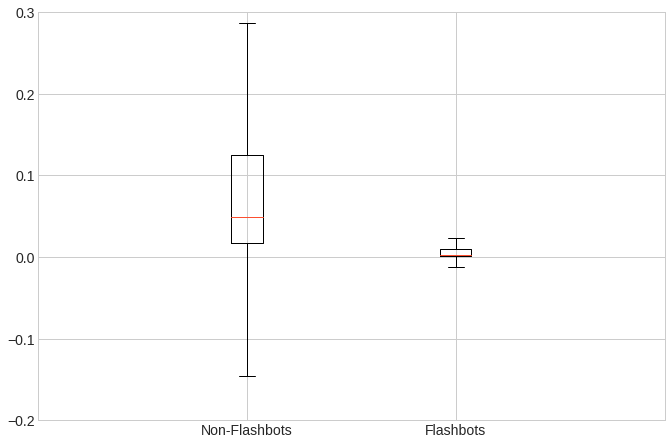

In [58]:
plt.style.use(style)
fig, ax = plt.subplots(figsize=(10, 7))
#fig.patch.set_facecolor('white')

#miner_profits = [non_fb_txs.cost_eth, fb_miner_after_df.cost_eth]
searcher_profits = [non_fb_txs.profit_eth, fb_miner_after_df.profit_eth]
profit_labels = ["Non-Flashbots", "Flashbots"]

#ax[0].boxplot(x=miner_profits, notch=False, sym='', labels=profit_labels)
ax.boxplot(x=searcher_profits, notch=False, sym='', labels=profit_labels)

#ax[0].set_ylabel("Insertion Profit (ETH)")
#ax[0].set_xlabel("Miners")
#ax.set_xlabel("Non-Miners")
ax.set_ylim([-0.2, 0.3])
ax.set_xlim([0, 3])

print(f"Non-Miner avg. profit (non-Flashbots): {non_fb_txs.profit_eth.mean()}")
print(f"Non-Miner avg. profit (Flashbots): {fb_miner_after_df.profit_eth.mean()}")
print(f"Non-Miner median profit (non-Flashbots): {non_fb_txs.profit_eth.median()}")
print(f"Non-Miner median profit (Flashbots): {fb_miner_after_df.profit_eth.median()}")
print(f"Non-Miner std. profit (non-Flashbots): {non_fb_txs.profit_eth.std()}")
print(f"Non-Miner std. profit (Flashbots): {fb_miner_after_df.profit_eth.std()}")

print(f"Average decrease in profit: {1.0 - fb_miner_after_df.profit_eth.mean()/non_fb_txs.profit_eth.mean()}")

#plt.tight_layout() 

#plt.show()
plt.savefig('figures/non_miners_insertion_profits.pdf', bbox_inches='tight', facecolor='white')


This plot shows that miners are seeing slightly higher profits when using
Flashbots than without Flashbots. This comes at the cost of somewhat increased
variance. Conversely, searchers (or in the non-Flashbots case: non-miners) see
lower profit, but lower variance. Since the average profit is the _expected_
profit, we can infer that searchers are only participating in Flashbots because
miners are participating. 

## Gas price variation

It is possible that Flashbots would cause the gas pricing dynamics to change. As such, we will plot the gas prices over time to discern any patterns.

In [60]:
def gas_price_extraction_pipeline(which_tx):
    return [
        {
            "$match":is_non_flashbots_query
        },
        {
            "$project": {
                "block_number": "$block_number",
                "block_timestamp": "$block_timestamp",
                "gasPrice": which_tx,
            }
        },
    ]

pipeline1 = gas_price_extraction_pipeline("$first_transaction.gasPrice")
pipeline2 = gas_price_extraction_pipeline("$second_transaction.gasPrice")

non_fb_txs_raw1 = pd.DataFrame(list(confirmed_mevs.aggregate(pipeline1)))
non_fb_txs_raw2 = pd.DataFrame(list(confirmed_mevs.aggregate(pipeline2)))

non_fb_txs_df = pd.concat([non_fb_txs_raw1, non_fb_txs_raw2], ignore_index=True).sort_values(by='block_number')
non_fb_txs_df.index = pd.to_datetime(non_fb_txs_df["block_timestamp"], unit='s')

non_fb_txs_df.insert(3, 'counter', 1)
non_fb_txs_df["daily_rolling_sum"] = non_fb_txs_df.rolling("1D").sum().counter

In [62]:
fb_insertions = pd.DataFrame(list(confirmed_mevs.find(is_flashbots_query, {"block_number":1, "block_timestamp": 1}))).sort_values(by='block_number').dropna()
fb_insertions.index = pd.to_datetime(fb_insertions["block_timestamp"], unit='s')
fb_insertions.insert(3, 'counter', 1)
fb_insertions["daily_rolling_sum"] = fb_insertions.rolling("1D").sum().counter

In [64]:
non_fb_insertions = pd.DataFrame(list(confirmed_mevs.find(is_non_flashbots_query, {"block_number":1, "block_timestamp": 1}))).sort_values(by='block_number').dropna()
non_fb_insertions.index = pd.to_datetime(non_fb_insertions["block_timestamp"], unit='s')
non_fb_insertions.insert(3, 'counter', 1)
non_fb_insertions["daily_rolling_sum"] = non_fb_insertions.rolling("1D").sum().counter

In [66]:
all_detected_insertions = pd.DataFrame(list(confirmed_mevs.find({}, {"block_number":1, "block_timestamp": 1, "miner": 1}))).sort_values(by='block_number').dropna()
all_detected_insertions.index = pd.to_datetime(all_detected_insertions["block_timestamp"], unit='s')
all_detected_insertions.insert(3, 'counter', 1)
all_detected_insertions["daily_rolling_sum"] = all_detected_insertions.rolling("1D").sum().counter

In [68]:
fb_all_txs = pd.DataFrame(list(flashbots_txs.find({}, {"block_number":1, "miner":1}))).sort_values(by='block_number')
fb_all_txs.insert(2, 'counter', 1)

# This really should be a timeseries, need different data
fb_all_txs["daily_rolling_sum"] = fb_all_txs.rolling(blocks_per_day).sum().counter

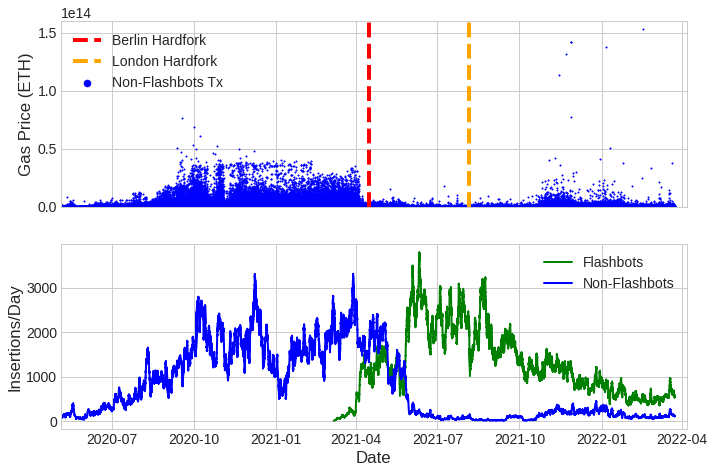

In [70]:
plt.style.use(style)
fig, ax = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
#fig.patch.set_facecolor('white')
fig.set_figwidth(10)
fig.set_figheight(7)

ax[0].set_xlim([datetime.datetime(2020, 5, 4, 20, 5, 27), datetime.datetime(2022, 4, 6, 20, 5, 27)])
ax[0].set_ylim([0, 1.6e14])
ax[0].scatter(non_fb_txs_df.index, non_fb_txs_df.gasPrice, s=2, color='blue', label="Non-Flashbots Tx", marker='o')

ax[0].axvline(x=datetime.datetime(2021, 4, 15, 10, 7, 3), color='red', linestyle='--', label='Berlin Hardfork')
ax[0].axvline(x=datetime.datetime(2021, 8, 5, 12, 33, 42), color='orange', linestyle='--', label='London Hardfork')

#ax[0].axvline(x=12965000, color='yellow', linestyle='--') #london


#ax[0].set_xlabel("Date")
ax[0].set_ylabel("Gas Price (ETH)")

ax[0].legend(markerscale=5.0)


ax[1].set_xlim([datetime.datetime(2020, 5, 4, 20, 5, 27), datetime.datetime(2022, 4, 6, 20, 5, 27)])
ax[1].plot(fb_insertions.index, fb_insertions['daily_rolling_sum'], color='green', label="Flashbots", linewidth=2)
ax[1].plot(non_fb_insertions.index, non_fb_insertions['daily_rolling_sum'], color='blue', label="Non-Flashbots", linewidth=2)

## This line doesn't add much, becuase all the txs are non-flashbots early on, and then mostly 
## Flashbots more recently
#ax[1].plot(all_detected_insertions.index, all_detected_insertions['daily_rolling_sum'], color='red', label="Total", linewidth=2)

ax[1].set_xlabel("Date")
ax[1].set_ylabel("Insertions/Day")

ax[1].legend(markerscale=5.0)

#ax[2].set_xlim([10000071, 14444710])
#ax[2].plot(fb_all_txs.index, fb_all_txs.rolling(blocks_per_day).sum().counter, color='green', label="Flashbots")

#ax[2].set_xlabel("Block Number")
#ax[2].set_ylabel("Flashbots (Total) Txs/Day")


#ax[2].legend(markerscale=5.0)

plt.savefig('figures/gas_price_txs_per_day.png', bbox_inches='tight', facecolor='white', dpi=300)


We hypothesize that the steep valley in the plot may coincide with the popularity of Flashbots over time. This data does not exactly support that conclusion, however. There is, indeed, a clear rise and fall in Flashbots popularity, and the length of the plateau looks about right, but it is offset from the gas price valley.

The top plot is only the gas prices of _insertion_ transactions. By just doing insertions (in top plot) we remove noise, because insertions are most affected by Flashbots.

**TODO** What if we look at the gas prices of _all_ transactions in the Flashbots epoch?

# Anomalies
A number of transactions in the Flashbots epoch yielded negative profit for
searchers which should not happen. A searcher standing to make negative profit
would not forward such a bundle to a miner. Here we explore those transactions
in depth.

In [72]:


unprofitable_fb_count = confirmed_mevs.count_documents(unprofitable_fb_query)
print(f"""In the Flashbots epoch, there have been {unprofitable_fb_count} unprofitable MEVs out of a total of {flashbots_txs_count} transactions. About {unprofitable_fb_count/flashbots_txs_count * 100:.2f}%.""")

def sum_unprofitable(currency):
    match = is_fb_after_fb_query | unprofitable_tx_query
    group = {"_id": f"profit_{currency}", "Sum": {"$sum": f"$profit_{currency}"}}
    pipeline = make_pipeline(match, group)
    return list(confirmed_mevs.aggregate(pipeline))[0]['Sum']
    
def sum_unprofitable_eth():
    return sum_unprofitable("eth")

def sum_unprofitable_usd():
    return sum_unprofitable("usd")

print(f"Unprofitable transactions in Flashbots total {-1*sum_unprofitable_eth():.2f} ETH or {locale.currency(-1*sum_unprofitable_usd(), grouping=True)} (USD).")

In the Flashbots epoch, there have been 7666 unprofitable MEVs out of a total of 485680 transactions. About 1.58%.
Unprofitable transactions in Flashbots total 113.67 ETH or $378,399.40 (USD).


In [74]:
pprint(list(confirmed_mevs.find(unprofitable_fb_query).sort("block_number", ASCENDING).limit(2)))

[{'_id': ObjectId('61bb866216eaf6510bbbf7bd'),
  'block_number': 12021015,
  'block_timestamp': 1615515848,
  'bot_address': '0xf8f50c9f86D9B6a5C612Ce3d05508a242cB079cd',
  'cost_eth': 0.12906520323961468,
  'cost_usd': 235.6804793719564,
  'eth_usd_price': 1826.0574768119818,
  'exchange_address': '0x4Dd26482738bE6C06C31467a19dcdA9AD781e8C4',
  'exchange_name': 'Uniswap V2',
  'first_transaction': {'from': '0x0000000023152Fb76626201d30577Eea74f26dBe',
                        'gas': 1500000,
                        'gasPrice': 0,
                        'hash': '0x067ec00d2c898baeecaa683983c2142a6ff4e060ff128f27a985faead7461807',
                        'input': '0x000006e10000000000000000000000000000000000000000000000005f7042ac62ef68a40000000000000000000000000b38210ea11411557c13457d4da7dc6ea731b88a0000000000000000000000004dd26482738be6c06c31467a19dcda9ad781e8c4',
                        'nonce': 3,
                        'to': '0xf8f50c9f86D9B6a5C612Ce3d05508a242cB079cd',
           

**Question for Christof**: in the above two insertions, both are using the same
exchange (Uniswap V2), but have different `exchange_address`es. Why is that?

**Answer**: This is probably okay. Not only will each token have its own exchange address, but the addresses themselves may change over time as the code is updated.

In [76]:
cdf_xlabels = {
    "exchange_address": "Exchange addresses", 
    "miner": "Flashbots miners",
    "bot_address": "Bot addresses",
    "token_address": "Token addresses",
    "first_transaction.to": "Contract addresses",
}


def plot_cdf(data, ax, bins, xname, xmin=None, xmax=None, more_label=""):
    ax.hist(data, bins=bins, cumulative=True, histtype='stepfilled', density=True, linewidth=2)
    ax.set_xlim(xmin=xmin, xmax=xmax)
    ax.set_xlabel(cdf_xlabels.get(xname, xname) + more_label)
    
    
def count_anomalies(anomaly_name, bins, ax1, ax2, xmin1=None, xmin2=None, xmax1=None, xmax2=None):
    match = is_fb_after_fb_query | unprofitable_tx_query
    group = {"_id": f"${anomaly_name}", "Counts": {"$sum": 1}}
    pipeline = make_pipeline(match, group)
    anomaly_counts = pd.DataFrame(list(confirmed_mevs.aggregate(pipeline)))
    plot_cdf(anomaly_counts.Counts, ax1, bins, anomaly_name, xmin=xmin1, xmax=xmax1, more_label=" (unprofitable)")
    
    all_pipeline = make_pipeline(is_fb_after_fb_query, group)
    all_counts = pd.DataFrame(list(confirmed_mevs.aggregate(all_pipeline)))
    plot_cdf(all_counts.Counts, ax2, bins, anomaly_name, xmin=xmin2, xmax=xmax2, more_label=" (all)")

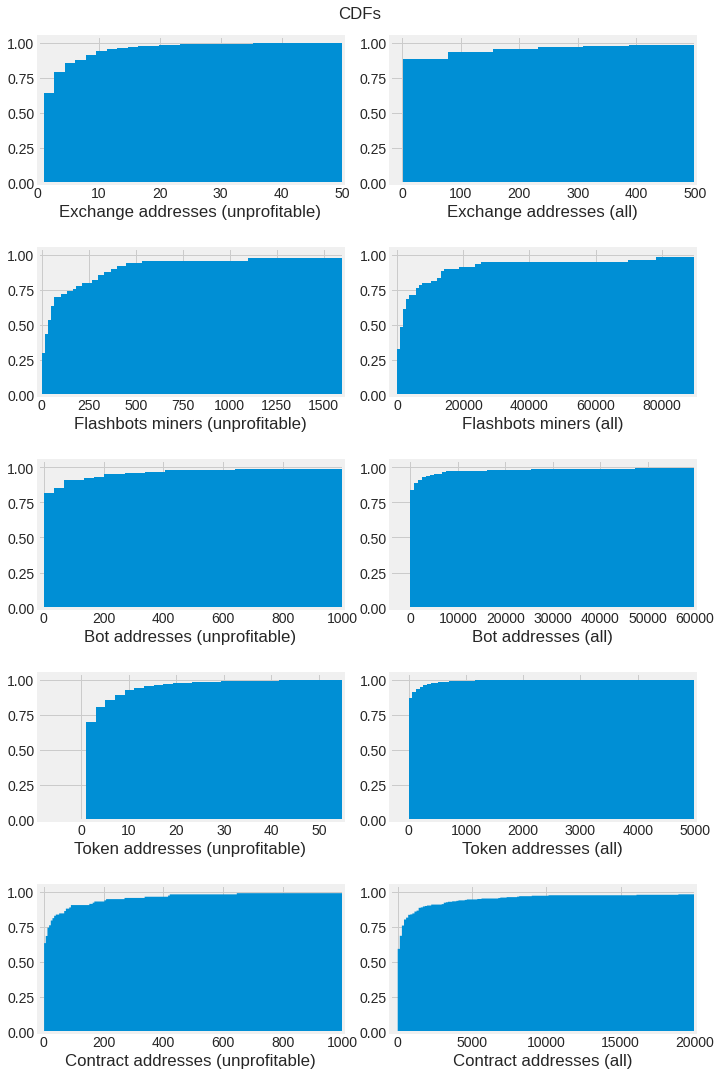

In [78]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(5,2)
fig.patch.set_facecolor('white')
fig.set_figwidth(10)
fig.set_figheight(15)

fig.suptitle("CDFs")
fig.tight_layout(h_pad=3)

count_anomalies("exchange_address", 60, ax[0, 0], ax[0, 1], xmin1=0, xmin2=-20, xmax1=50, xmax2=500)
count_anomalies("miner", 100, ax[1, 0], ax[1, 1], xmin1=-20, xmin2=-2000, xmax1=1600, xmax2=90000)
count_anomalies("bot_address", 100, ax[2, 0], ax[2, 1], xmin1=-20, xmin2=None, xmax1=1000, xmax2=60000)
count_anomalies("token_address", 100, ax[3, 0], ax[3, 1], xmin1=None, xmin2=None, xmax1=55, xmax2=5000)
count_anomalies("first_transaction.to", 600, ax[4, 0], ax[4, 1], xmin1=-20, xmin2=-500, xmax1=1000, xmax2=20000)

The above plots show CDFs of the frequency of various attributes of MEV transactions. The left column represents the CDF of only *unprofitable* transactions, while the right column includes *all* MEV transaction. We will discuss them one row at a time.

1. This represents the frequency of specific exchange addresses. We see in the right plot that more than ~90% of MEV transactions were conducted on less than ~5-10 exchanges. On the left we see that some exchanges are involved in more unprofitable MEVs than others, but there is not enough evidence to claim this is anything beyond some exchanges are simply involved in more tranactions.
2. We see a similar story for the Flashbots miners. Not enough evidence to claim this is anything beyond some miners are mining more unprofitable MEVs because they have more mining power and are mining more of everything.
3. Same story.
4. Same story.
5. Same story.

# Miner Clustering

Flashbots has the stated goal of democratizing MEV. If this has been the case, we should expect to see the same CDF of per-miner profits both before and after the advent of Flashbots. We test this hypothesis below.

In [80]:
def miner_profit_distribution(match):
    pipeline = make_pipeline(match, {"_id": "$miner", "profits": {"$sum": "$cost_eth"}})
    return pd.DataFrame(list(confirmed_mevs.aggregate(pipeline)))

def miner_profit_timeseries(match):
    pipeline = make_pipeline(match, {"_id": "$miner", "profits": {"$sum": "$cost_eth"}})
    return pd.DataFrame(list(confirmed_mevs.aggregate(pipeline)))


In [82]:
miner_profits_before_fb = miner_profit_distribution(before_fb_query)
miner_profits_fb_after_fb = miner_profit_distribution(is_fb_after_fb_query)
miner_profits_non_fb_after_fb = miner_profit_distribution(non_fb_after_query)

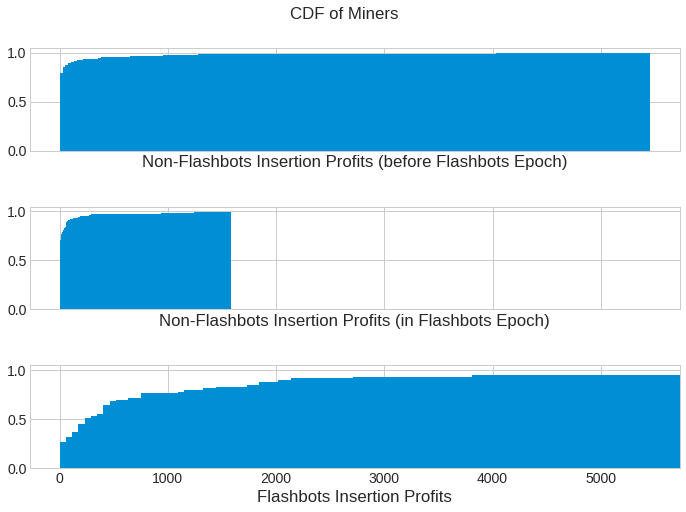

In [83]:
plt.style.use(style)
fig, ax = plt.subplots(3,1, sharex=True)
fig.patch.set_facecolor('white')
fig.set_figwidth(10)
fig.set_figheight(7)

fig.suptitle("CDF of Miners")
fig.tight_layout(h_pad=3)

plot_cdf(miner_profits_before_fb.profits, ax[0], 200, "Non-Flashbots Insertion Profits (before Flashbots Epoch)")
plot_cdf(miner_profits_non_fb_after_fb.profits, ax[1], 200, "Non-Flashbots Insertion Profits (in Flashbots Epoch)")
plot_cdf(miner_profits_fb_after_fb.profits, ax[2], 200, "Flashbots Insertion Profits")

plt.savefig('figures/miner_clustering.pdf', bbox_inches='tight', facecolor='white')


These CDFs indicate that there is higher diversity among miners performing frontrunning now than there was before flashbots. Profits are more evenly distributed among miners. There is still a longtail distribution, but it is significantly less skewed.

# Count MEVs Per Miner

In [84]:
def calculate_blocks_in_range(start, end, txs):
    return txs[(txs["block_number"] > start) & 
               (txs["block_number"] < end)]

def calculate_fb_blocks_in_range(start, end):
    return calculate_blocks_in_range(start, end, fb_all_txs)

def calculate_non_fb_blocks_in_range(start, end):
    return calculate_blocks_in_range(start, end, all_detected_insertions)

pre_fb_monthly_block_ranges = [
    (10176690, 10370273), # June 2020
    (10370274, 10570484), # July 2020
    (10570485, 10771924), # August 2020
    (10771925, 10966873), # Sept 2020
    (10966874, 11167816), # Oct 2020
    (11167817, 11363269), # Nov 2020
    (11363270, 11565018), # December 2020
]

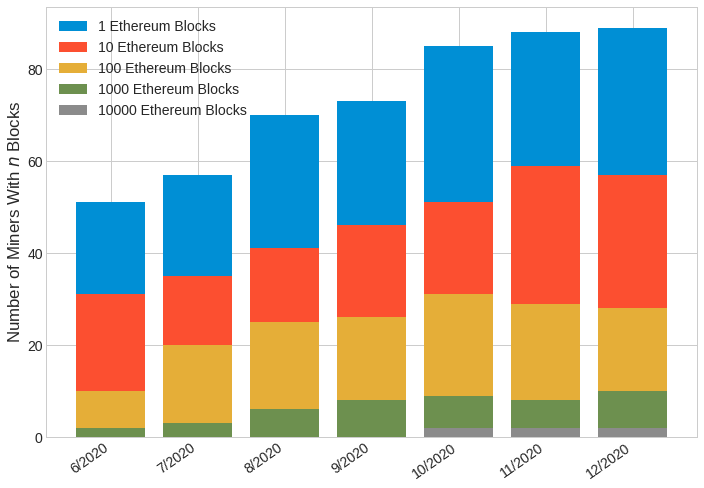

In [85]:
plt.style.use(style)
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
fig.set_figwidth(10)
fig.set_figheight(7)

ns = [1, 10, 100, 1000, 10000]

pre_fb_months = [f'{i}/2020' for i in range(6, 13)]

def group_by_miner(df):
    return df.groupby("miner").sum()

def count_rows_above_n(df, n, label='counter'):
    return len(df[df[label] >= n])

def count_rows_above_n_date_range(n):
    return [count_rows_above_n(group_by_miner(calculate_non_fb_blocks_in_range(start, end)), n) for start, end in pre_fb_monthly_block_ranges]


n_miners = pd.DataFrame([count_rows_above_n_date_range(n) for n in ns])
n_miners.columns = pre_fb_months


# plot bars in stack manner
plt.bar(pre_fb_months, n_miners.iloc[0])

for i in range(1, len(ns)):
    plt.bar(pre_fb_months, n_miners.iloc[i]) #, bottom=n_miners.iloc[0:i].sum())


#plt.xlabel("Dates")
plt.ylabel("Number of Miners With $n$ Blocks")
plt.legend([f"{n} Ethereum Blocks" for n in ns])
#plt.title("Scores by Teams in 4 Rounds")


for label in ax.get_xticklabels(which='major'):
    label.set(rotation=35, horizontalalignment='right')
    
fig.tight_layout()

plt.savefig('figures/non_fb_blocks_per_miner.pdf', bbox_inches='tight', facecolor='white')

## Hashpower and Flashbots Adoption
We suspect that Flashbots adoption has increased over time, and has perhaps already peaked. We attempt to measure this adoption rate.

In [5]:
BLOCKS_PER_MONTH = 202292
JAN_1_2022_BLOCK = 11565019
SPAN_OF_MEASUREMENT_MONTHS = 14


hashpower_analysis_df = pd.DataFrame()
# define new series
starts = pd.Series([i for i, _ in monthly_block_ranges])
ends = pd.Series([j for _, j in monthly_block_ranges])
months_s = pd.Series(months)

# Calculate total blocks mined per month (difference of bounds in above span)
blocks_per_month_s = pd.Series([end-start for start, end in monthly_block_ranges])

# Sum the number of flashbots blocks in each span
fb_blocks_monthly_s = pd.Series([len(calculate_fb_blocks_in_range(start, end)) for start, end in monthly_block_ranges])

#insert new series as column
hashpower_analysis_df.insert(len(hashpower_analysis_df.columns), 'months', months_s)
hashpower_analysis_df.insert(len(hashpower_analysis_df.columns), 'starts', starts)
hashpower_analysis_df.insert(len(hashpower_analysis_df.columns), 'ends', ends)
hashpower_analysis_df.to_csv("monthly_block_ranges.csv", columns=['months', 'starts', 'ends'])
hashpower_analysis_df.insert(len(hashpower_analysis_df.columns), 'total_blocks', blocks_per_month_s)
hashpower_analysis_df.insert(len(hashpower_analysis_df.columns), 'fb_blocks', fb_blocks_monthly_s)

hashpower_analysis_df['fb_proportion'] = hashpower_analysis_df['fb_blocks']/hashpower_analysis_df['total_blocks']
hashpower_analysis_df['non_fb_proportion'] = 1.0 - hashpower_analysis_df['fb_proportion']
hashpower_analysis_df

NameError: name 'calculate_fb_blocks_in_range' is not defined

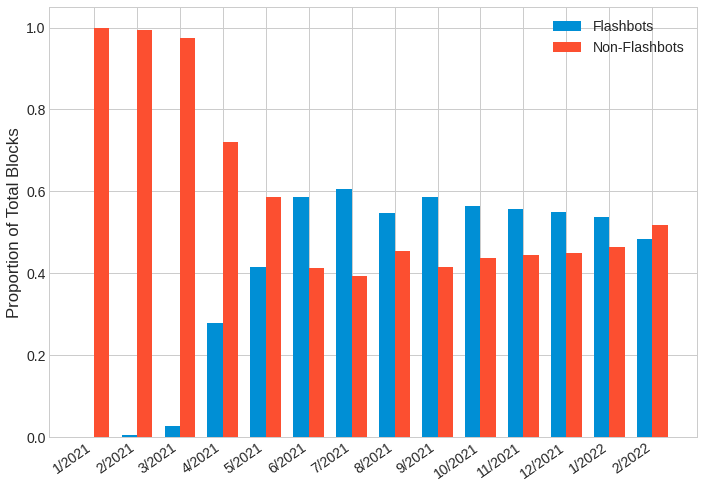

In [87]:
plt.style.use(style)
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
fig.set_figwidth(10)
fig.set_figheight(7)



x = np.arange(len(months))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, hashpower_analysis_df['fb_proportion'], width, label='Flashbots')
rects2 = ax.bar(x + width/2, hashpower_analysis_df['non_fb_proportion'], width, label='Non-Flashbots')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Proportion of Total Blocks')
#ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(months)

ax.legend()


for label in ax.get_xticklabels(which='major'):
    label.set(rotation=35, horizontalalignment='right')
    
fig.tight_layout()

plt.savefig('figures/fb_hashpower.pdf', bbox_inches='tight', facecolor='white')

The Flashbots bars in the above plot correspond roughly to the hashing power of Flashbots miners. We surmise this by calculating the proportion of blocks (per month) that include Flashbots transactions. As these are usually more profitable than non-Flashbots transactions (because they include a miner fee), it stands to reason that miners that are participating in Flashbots will usually include Flashbots transactions in the blocks they mine. This means implies that the proportion of Flashbots blocks over a given time span, corresponds to the hashing power of Flashbots miners. **For a more accurate estimation, we should make an estimate for how likely a block is to contain a Flashbots bundle _if_ it is a part of Flashbots.**

In the above plot, we see that in July 2021 Flashbots peaks at around 60% hashing power. It then declines to roughly 50%, and as of February 2022 even dips back below non-Flashbots hashing power.

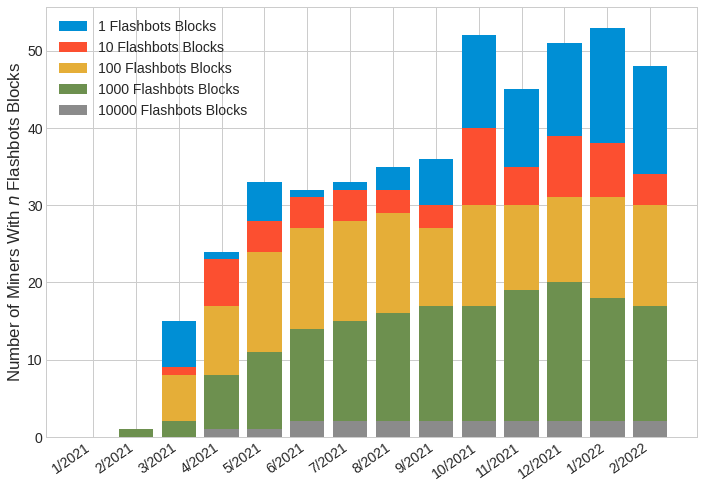

In [88]:
plt.style.use(style)
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
fig.set_figwidth(10)
fig.set_figheight(7)

ns = [1, 10, 100, 1000, 10000]

def group_by_miner(df):
    return df.groupby("miner").sum()

def count_rows_above_n(df, n, label='counter'):
    return len(df[df[label] >= n])

def count_rows_above_n_date_range(n):
    return [count_rows_above_n(group_by_miner(calculate_fb_blocks_in_range(start, end)), n) for start, end in monthly_block_ranges]


n_miners = pd.DataFrame([count_rows_above_n_date_range(n) for n in ns])
n_miners.columns = months


# plot bars in stack manner
plt.bar(months, n_miners.iloc[0])

for i in range(1, len(ns)):
    plt.bar(months, n_miners.iloc[i]) #, bottom=n_miners.iloc[0:i].sum())


#plt.xlabel("Dates")
plt.ylabel("Number of Miners With $n$ Flashbots Blocks")
plt.legend([f"{n} Flashbots Blocks" for n in ns])
#plt.title("Scores by Teams in 4 Rounds")


for label in ax.get_xticklabels(which='major'):
    label.set(rotation=35, horizontalalignment='right')
    
fig.tight_layout()

plt.savefig('figures/fb_hashpower_per_miner.pdf', bbox_inches='tight', facecolor='white')

The above plot shows the number of miners (per month) that have mined at least _n_ Flashbots blocks. The idea is to give some indication of how top-heavy the miner distribution is.

In [89]:
dfs = []
for start_end, month in zip(monthly_block_ranges, months):
    start, end = start_end
    dfs.append(calculate_fb_blocks_in_range(start, end).groupby('miner').sum()['counter'])

df_merged_fb = reduce(lambda left,right: pd.merge(left,right,on=['miner'], how='outer'), dfs)

df_merged_fb.columns = months

df_merged_fb = df_merged_fb.fillna(0)
df_merged_fb
#dfs[1]
    #df.to_csv(f"flashbots_miners_{month.replace('/', '_')}.csv", columns=['counter'])

/run/user/1000/ipykernel_625928/1242087157.py:6: FutureWarning: Passing 'suffixes' which cause duplicate columns {'counter_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_merged_fb = reduce(lambda left,right: pd.merge(left,right,on=['miner'], how='outer'), dfs)


,1/2021,2/2021,3/2021,4/2021,5/2021,6/2021,7/2021,8/2021,9/2021,10/2021,11/2021,12/2021,1/2022,2/2022
miner,,,,,,,,,,,,,,
0xD224cA0c819e8E97ba0136B3b95ceFf503B79f53,0.0,1026.0,1333.0,2285.0,2534.0,3196.0,1210.0,116.0,0.0,31.0,0.0,0.0,0.0,0.0
0x00192Fb10dF37c9FB26829eb2CC623cd1BF599E8,0.0,0.0,169.0,955.0,859.0,1216.0,1816.0,1719.0,2525.0,2780.0,3465.0,3719.0,3439.0,3385.0
0x002e08000acbbaE2155Fab7AC01929564949070d,0.0,0.0,106.0,315.0,161.0,378.0,356.0,619.0,1114.0,1062.0,880.0,495.0,420.0,599.0
0x04668Ec2f57cC15c381b461B9fEDaB5D451c8F7F,0.0,0.0,384.0,5948.0,6193.0,4600.0,3720.0,1016.0,0.0,0.0,0.0,0.0,0.0,0.0
0x06B8C5883Ec71bC3f4B332081519f23834c8706E,0.0,0.0,1.0,192.0,596.0,124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0xfC8430D9c04DDc8bB2b549EcF2f42B230E9375dE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
0xfaD45A9aB2c408f7e6f8d4786F0708171169C2c3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0x02cDf81110F81846387a9C15a432f2df1eAac05f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [90]:
dfs = {month: pd.read_csv(f"resources/count/{month.replace('/', '_')}_count.csv") for month in months}


df_merged = reduce(lambda left,right: pd.merge(left,right,on=['miner'], how='outer'), dfs.values())

cols = ['miner']
cols.extend(months)
df_merged.columns = cols
df_merged.set_index('miner', inplace=True)
df_merged

fbs_per_month = []
for month in months:
    # miners who've mined at least one FB block in month
    fb_miners_month = df_merged_fb[df_merged_fb[month] > 0][month]
    fbs_per_month.append(pd.merge(fb_miners_month, df_merged[month], on=['miner'], how='inner', suffixes=("_fb", ""))[month])


# these are the blocks per month, but only from miners who have mined at least one FB block in that month
df_merged = reduce(lambda left,right: pd.merge(left,right,on=['miner'], how='outer'), fbs_per_month)    

hashpower_analysis_df = hashpower_analysis_df.assign(fb_block_totals=df_merged.sum(axis=0).tolist())
hashpower_analysis_df['hash_rates'] = hashpower_analysis_df['fb_block_totals']/hashpower_analysis_df['total_blocks']
if 'months' in hashpower_analysis_df.columns:
    hashpower_analysis_df.set_index('months', inplace=True)

hashpower_analysis_df

/run/user/1000/ipykernel_625928/3851922762.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'counter_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_merged = reduce(lambda left,right: pd.merge(left,right,on=['miner'], how='outer'), dfs.values())


,starts,ends,total_blocks,fb_blocks,fb_proportion,non_fb_proportion,fb_block_totals,hash_rates
months,,,,,,,,
1/2021,11565019,11766938,201919,0,0.000000,1.000000,0.0,0.000000
2/2021,11766939,11948959,182020,1026,0.005637,0.994363,4935.0,0.027112
3/2021,11948960,12150244,201284,5400,0.026828,0.973172,124316.0,0.617615
4/2021,12150245,12344944,194699,54352,0.279159,0.720841,165191.0,0.848443
5/2021,12344945,12545218,200273,83103,0.414949,0.585051,195524.0,0.976287
6/2021,12545219,12738508,193289,113466,0.587028,0.412972,180585.0,0.934275
7/2021,12738509,12936339,197830,120014,0.606652,0.393348,185783.0,0.939104
8/2021,12936340,13136426,200086,109320,0.546365,0.453635,198295.0,0.991049
9/2021,13136427,13330089,193662,113286,0.584968,0.415032,192063.0,0.991743


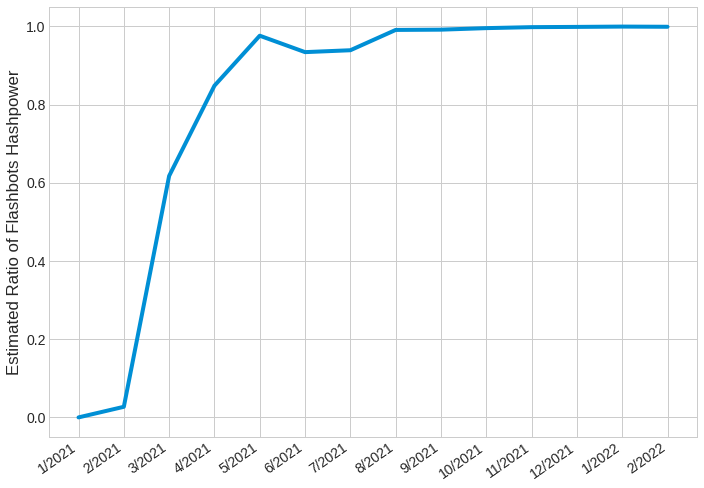

In [91]:
plt.style.use(style)
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
fig.set_figwidth(10)
fig.set_figheight(7)

plt.ylabel("Estimated Ratio of Flashbots Hashpower")


for label in ax.get_xticklabels(which='major'):
    label.set(rotation=35, horizontalalignment='right')

ax.plot(months, hashpower_analysis_df['hash_rates'])

fig.tight_layout()
plt.savefig('figures/fb_total_hashpower.pdf', bbox_inches='tight', facecolor='white')

This is an estimate of the Flashbots hashrate as a percentage of total Ethereum hashrate over time.

### Searchers over time

In [6]:
def get_all_fb_txs(start, end):
    pipeline = [
        {
            "$match": {
                #"block_number": 14566521
                "block_number": {"$gt": start, "$lte": end}
            }
        },
        {
            "$project": {
                "transactions": 1
            }
        },
        {
            "$unwind": "$transactions"
        },
        {
            "$replaceRoot": {"newRoot": "$transactions"}
        },
    ]
    
    return pd.DataFrame(flashbots_txs.aggregate(pipeline))


def get_all_sandwich_txs(start, end):
    pipeline = [
        {
            "$match": {
                #"block_number": 14566521
                "block_number": {"$gt": start, "$lte": end}
            }
        },
        {
            "$project": {
                "tx1": "$first_transaction.hash",
                "tx2": "$second_transaction.hash",
                "_id": 0,
            }
        },

    ]
    
    return pd.DataFrame(insertions.aggregate(pipeline))

def get_all_liquidation_txs(start, end):
    pipeline = [
        {
            "$match": {
                #"block_number": 14566521
                "block_number": {"$gt": start, "$lte": end}
            }
        },
        {
            "$project": {
                "tx": "$transaction.hash",
                "_id": 0,
            }
        },

    ]
    
    return pd.DataFrame(liquidations.aggregate(pipeline))

# Data has same structure as liquation, so we can use the same aggregation
def get_all_arbitrage_txs(start, end):
    pipeline = [
        {
            "$match": {
                #"block_number": 14566521
                "block_number": {"$gt": start, "$lte": end}
            }
        },
        {
            "$project": {
                "tx": "$transaction.hash",
                "_id": 0,
            }
        },

    ]
    
    return pd.DataFrame(arbitrages.aggregate(pipeline))

def calculate_intersection(set1, set2, mev_type):
    if len(set1) == 0 or len(set2) == 0:
        return pd.DataFrame(columns=['eoa_address'])
    if mev_type == 'sandwich':
        intersection1 = pd.merge(set1, set2, how='inner', left_on=['transaction_hash'], right_on=['tx1'])
        intersection2 = pd.merge(set1, set2, how='inner', left_on=['transaction_hash'], right_on=['tx2'])
        return pd.concat([intersection1, intersection2])
    elif mev_type == 'liquidation' or mev_type == 'arbitrage':
        return pd.merge(set1, set2, how='inner', left_on=['transaction_hash'], right_on=['tx'])
    else:
        raise Exception(f"{mev_type} is not a valid mev_type")

def count_mevs(set1, set2, mev_type):
    return len(calculate_intersection(set1, set2, mev_type))

def count_searchers(set1, set2, mev_type):
    return len(calculate_intersection(set1, set2, mev_type).groupby('eoa_address').nunique())


In [7]:
start, end = monthly_block_ranges[1]
print(start, end)
fb_txs = get_all_fb_txs(start, end)
#sandwich_txs = get_all_sandwich_txs(start, end)
liquidation_txs = get_all_liquidation_txs(start, end)
arbitrage_txs = get_all_arbitrage_txs(start, end)

len(calculate_intersection(fb_txs, arbitrage_txs, 'arbitrage'))
#count_mevs(fb_txs, arbitrage_txs, 'arbitrage')
#count_mevs(fb_txs, liquidation_txs, 'liquidation')

11766939 11948959


0

In [8]:
# number of MEVs by month
mev_counts_by_type = []
for start, end in monthly_block_ranges:
    print(start, end)
    fb_txs = get_all_fb_txs(start, end)
    if len(fb_txs) == 0:
        x = [0, 0, 0]
    else:
        sandwich_txs = get_all_sandwich_txs(start, end)
        liquidation_txs = get_all_liquidation_txs(start, end)
        arbitrage_txs = get_all_arbitrage_txs(start, end)
    
        x = [count_mevs(fb_txs, sandwich_txs, 'sandwich')] + [count_mevs(fb_txs, liquidation_txs, 'liquidation')] + [count_mevs(fb_txs, arbitrage_txs, 'arbitrage')]

    # account for other mev that are not sandwiches, arbitrages, and liquidations
    x.append(len(fb_txs) - sum(x))
    mev_counts_by_type.append(x)

11565019 11766938
11766939 11948959
11948960 12150244
12150245 12344944
12344945 12545218
12545219 12738508
12738509 12936339
12936340 13136426
13136427 13330089
13330090 13527858
13527859 13717846
13717847 13916165
13916166 14116760
14116761 14297758


In [9]:
# number of searchers by month
searchers_by_type = []
for start, end in monthly_block_ranges:
    print(start, end)
    fb_txs = get_all_fb_txs(start, end)
    if len(fb_txs) == 0:
        x = [0, 0, 0]
    else:
        sandwich_txs = get_all_sandwich_txs(start, end)
        liquidation_txs = get_all_liquidation_txs(start, end)
        arbitrage_txs = get_all_arbitrage_txs(start, end)
    
        x = [count_searchers(fb_txs, sandwich_txs, 'sandwich')] + [count_searchers(fb_txs, liquidation_txs, 'liquidation')] + [count_searchers(fb_txs, arbitrage_txs, 'arbitrage')]

    # account for other mev that are not sandwiches, arbitrages, and liquidations
    x.append(len(fb_txs) - sum(x))
    searchers_by_type.append(x)

11565019 11766938
11766939 11948959
11948960 12150244
12150245 12344944
12344945 12545218
12545219 12738508
12738509 12936339
12936340 13136426
13136427 13330089
13330090 13527858
13527859 13717846
13717847 13916165
13916166 14116760
14116761 14297758


In [10]:
mev_counts = pd.DataFrame(mev_counts_by_type, columns=['sandwiches', 'liquidations', 'arbitrages', 'other'])
#mev_counts.columns = months
mev_counts.insert(loc=0, column='months', value=months)
mev_counts

,months,sandwiches,liquidations,arbitrages,other
0,1/2021,0,0,0,0
1,2/2021,0,0,0,1293
2,3/2021,6970,1,283,7186
3,4/2021,68203,41,14786,92890
4,5/2021,84529,1061,30448,204781
5,6/2021,149028,1440,100255,382940
6,7/2021,143283,479,109347,394300
7,8/2021,129991,308,114850,273884
8,9/2021,99627,449,106838,294667
9,10/2021,73287,601,93028,450163


In [11]:
searchers = pd.DataFrame(searchers_by_type, columns=['sandwiches', 'liquidations', 'arbitrages', 'other'])
#mev_counts.columns = months
searchers.insert(loc=0, column='months', value=months)
searchers

,months,sandwiches,liquidations,arbitrages,other
0,1/2021,0,0,0,0
1,2/2021,0,0,0,1293
2,3/2021,17,1,26,14396
3,4/2021,178,33,332,175377
4,5/2021,170,166,1313,319170
5,6/2021,179,326,1728,631430
6,7/2021,243,205,1889,645072
7,8/2021,137,57,674,518165
8,9/2021,89,115,462,500915
9,10/2021,80,66,467,616466


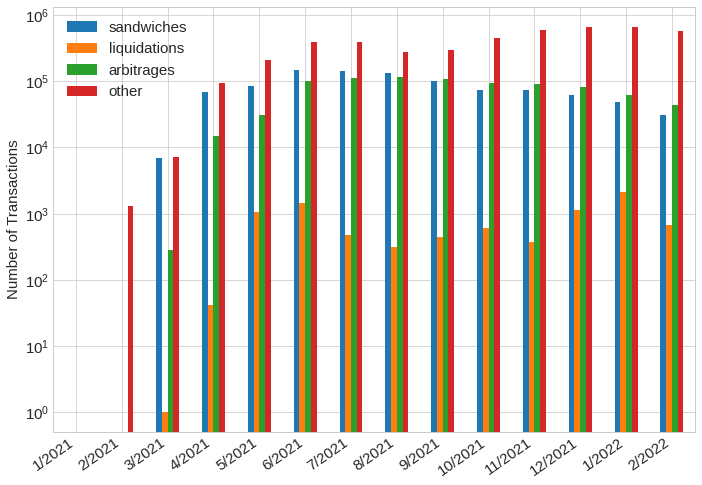

In [12]:
plt.style.use(style)
plt.rc('font', size=15) 
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
fig.set_figwidth(10)
fig.set_figheight(7)

mev_counts.plot(x='months',
                kind='bar',
                stacked=False,
                #title='Grouped Bar Graph with dataframe',
                ax=ax,
                logy=True,
                ylabel="Number of Transactions",
                xlabel=""
               )

for label in ax.get_xticklabels(which='major'):
    label.set(rotation=35, horizontalalignment='right')
    
fig.tight_layout()

plt.savefig('figures/mev_counts_by_type.pdf', bbox_inches='tight', facecolor='white')

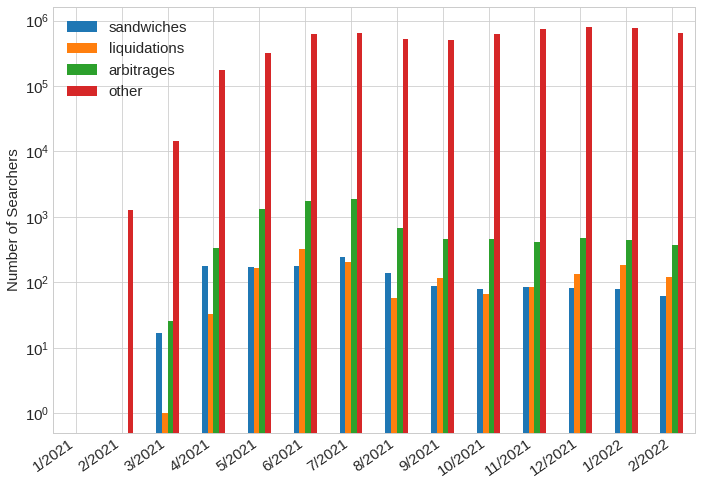

In [13]:
plt.style.use(style)
plt.rc('font', size=15) 
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
fig.set_figwidth(10)
fig.set_figheight(7)

searchers.plot(x='months',
                kind='bar',
                stacked=False,
                #title='Grouped Bar Graph with dataframe',
                ax=ax,
                logy=True,
                ylabel="Number of Searchers",
                xlabel=""
              )

for label in ax.get_xticklabels(which='major'):
    label.set(rotation=35, horizontalalignment='right')
    
fig.tight_layout()

plt.savefig('figures/searchers_by_type.pdf', bbox_inches='tight', facecolor='white')

# Individual Records

In [93]:
flashbots_txs.find_one()

{'_id': ObjectId('625584dfb137e08b17a73bcc'),
 'block_number': 14566521,
 'miner_reward': '27247571450490034',
 'miner': '0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8',
 'coinbase_transfers': '10253952591270884',
 'gas_used': 359510,
 'gas_price': '75790858252',
 'transactions': [{'transaction_hash': '0xaacc17e6e4880824427a2004cc986f3a3d17853eb87e20da8136d427e82bf00b',
   'tx_index': 0,
   'bundle_type': 'flashbots',
   'bundle_index': 0,
   'block_number': 14566521,
   'eoa_address': '0x663a6EfDa98b0f49cC316F676e15B9Bd3BeEBFE8',
   'to_address': '0x7f268357A8c2552623316e2562D90e642bB538E5',
   'gas_used': 192635,
   'gas_price': '88216673290',
   'coinbase_transfer': '0',
   'total_miner_reward': '16993618859219150'},
  {'transaction_hash': '0x7789a210b1da8f13f786a106c318d257b54d0a61f2b082b0fc02c9b9b4b35b3d',
   'tx_index': 0,
   'bundle_type': 'flashbots',
   'bundle_index': 1,
   'block_number': 14566521,
   'eoa_address': '0x6Cffc7fe15CAA05078e55c2EDE55FBBBcceEBc84',
   'to_address':

In [94]:
confirmed_mevs.find_one()

{'_id': ObjectId('61bb7533333c0e8b86bb910a'),
 'block_number': 10297325,
 'block_timestamp': 1592584902,
 'first_transaction': {'from': '0xaaa2e80AB7D7b3C216af30Fc8165E7823e74cc62',
  'gas': 250000,
  'gasPrice': 45000000001,
  'hash': '0x7387860db0779de93d0ba342d373d704c58c4c9d0a371fb8ba2f7ee4bf7bbd10',
  'input': '0x7ff36ab500000000000000000000000000000000000000000000000000000029c4494d980000000000000000000000000000000000000000000000000000000000000080000000000000000000000000aaa2e80ab7d7b3c216af30fc8165e7823e74cc62000000000000000000000000000000000000000000000000000000005eeced2c0000000000000000000000000000000000000000000000000000000000000002000000000000000000000000c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2000000000000000000000000d46ba6d942050d489dbd938a2c909a5d5039a161',
  'nonce': 5874,
  'to': '0xf164fC0Ec4E93095b804a4795bBe1e041497b92a',
  'transactionIndex': 143,
  'value': '796000000000000000',
  'type': '0x0'},
 'whale_transaction': {'from': '0xdaC071eDBe067499281F1272cf39F4CCB1e50a

In [36]:
liquidations.find_one()

{'_id': ObjectId('6254a1d8c5ece98b59e10bf6'),
 'block_number': 13261261,
 'block_timestamp': 1632122835,
 'miner': '0xc8F595E2084DB484f8A80109101D58625223b7C9',
 'transaction': {'from': '0xaAe71FCdff4ee4dE9c2Ab989EF10F624BDc430aa',
  'gas': 1300002,
  'gasPrice': 49472030731,
  'maxFeePerGas': '0x15fae8fde3',
  'maxPriorityFeePerGas': '0x0',
  'hash': '0x05f3c0b8a93aadf497329108b5d44b4ce97a932da36b1bdeed4dfa49ce0d88c3',
  'input': '0xba9b5b63000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000c93ce9639d75fce64a16b7a282db8792080d01580000384000000002000000000000000000000000000066ae32178640813f3c32a9929520bfe4fef5d16700000000000000018904fb1ffa355ac20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000d06527d5e56a3495252a528c4987003b712860ee00000000000000000000000021011bc93d9e515b95

In [39]:
arbitrages.find_one()

{'_id': ObjectId('62422cc63c661b6cb5fdb4b8'),
 'block_number': 14089370,
 'block_timestamp': 1643308756,
 'transaction': {'from': '0x5AA3393e361C2EB342408559309b3e873CD876d6',
  'gas': 1000000,
  'gasPrice': 205826296434,
  'maxFeePerGas': '0x35e2473280',
  'maxPriorityFeePerGas': '0x3b9aca00',
  'hash': '0x94b33f6e4b6bffdd65c0a16f82ffe38271328ea11afa67e32d8d56dafe999d92',
  'input': '0x000000520000000000000000000000000000000000000000000000000000000000d6fc9a00000000000000000000000000000000000000000000000016f34264bd706f020000000000000000000000007a58c0be72be218b41c608b7fe7c5bb630736c71000000000000000000000000a52566764daa95487526ba31a2c3671a6a82d33600000000000000000000000083abecf7204d5afc1bea5df734f085f2535a997600000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000',
  'nonce': 41601,
  'to': '0x58418d6c83EfAB01ed78b0AC42E55af01eE77DbA',
  'transactionIndex': 2,
  'value': '0',
  'type': '0x2',
  'accessList': [],
 